# Lab session 5: Classification and Clustering

## Introduction

The aim of this lab (Lab session 5) is for students to get experience with **Classification** and **Clustering**, both covered in lecture 6, by using common Python libraries.

## Classification

In order to present functionalities for data classification and clustering in Python, we use the [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/) as part of a working example.

The dataset is stored in a file called ``mnist.pkl``, which is serialized by [pickle](https://docs.python.org/3/library/pickle.html).

In the snippet below, ``X`` is a matrix (numpy array) where each row corresponds to an observation and each column corresponds to a feature. Each observation is the result of *flattening* a 28 x 28 grayscale image of a handwritten digit into a vector. The list ``y`` (numpy array) contains the class (a digit from 0 to 9) corresponding to each observation (row) in the matrix ``X``.

For the sake of this tutorial, we select only the first 2000 observations (rows) from the original MNIST training dataset to expedite computations.

It is possible to use the ``matplotlib`` function ``imshow`` to visualise any observation by reshaping it appropriately. You may change the index ``i`` to select an observation for visualisation.




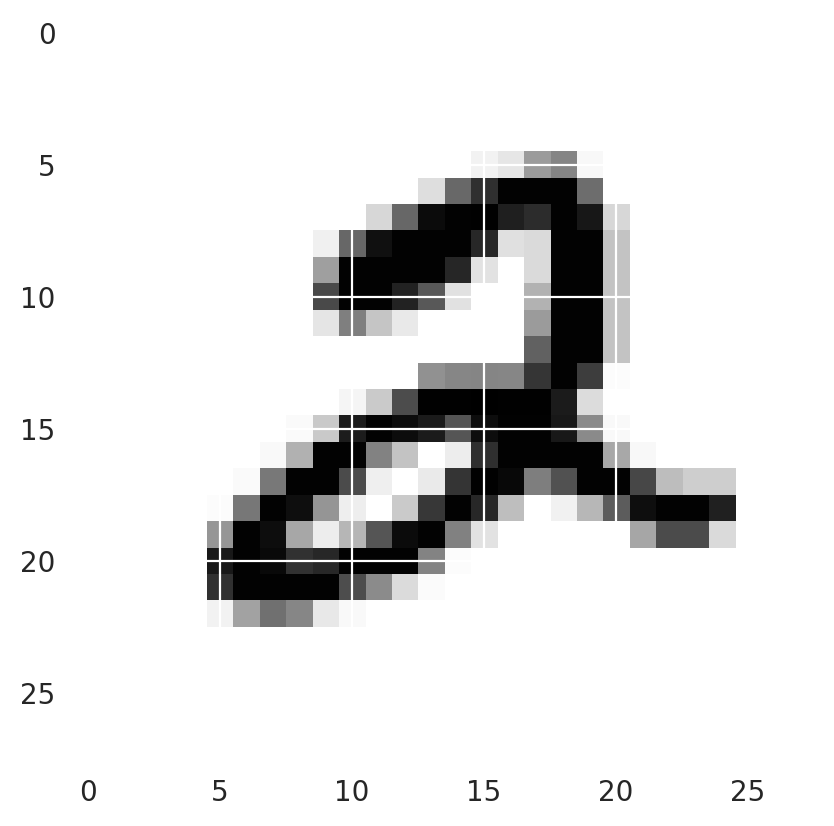

Observation index: 5. Class: 2.


In [4]:
# Configuring the appearance of ``seaborn`` graphics in this notebook
%config InlineBackend.figure_formats = set(['retina'])

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Selecting the training data from the original dataset
f = open('mnist.pkl', 'rb')
X, y = pickle.load(f, encoding='latin1')[0]
f.close()

# Subsampling
sample_size = 2000
X, y = X[:sample_size], y[:sample_size]

i = 5
plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()
print('Observation index: {0}. Class: {1}.'.format(i, y[i]))

The library ``sklearn`` implements all the learning algorithms that we covered during the lectures. Each algorithm is implemented by a class that provides a standard interface.

The class ``KNeighborsClassifier`` implements a k-nearest neighbour classification algorithm. The number of neighbours is specified by the constructor parameter ``n_neighbors``.

The method ``KNeighborsClassifier.fit`` is responsible for learning a classifier for a dataset represented by an observation matrix and a class array. This is precisely how our data is represented.

The method ``KNeighborsClassifier.score`` computes the accuracy of a classifier on a specific dataset. This method must be called after ``KNeighborsClassifier.fit``.

As we have seen, a one-nearest neighbour classifier always predicts the correct class for any observation that already exists in a dataset (as long as there are no equal observations with different classes), which is why we obtain 100% accuracy on the training set.


In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
print('Training dataset accuracy: {0}.'.format(knn.score(X, y)))

Training dataset accuracy: 1.0.


In order to evaluate the capacity of a k-nearest neighbour classifier to assign unseen observations to correct classes, it is necessary to split the original dataset into a training dataset and a test dataset.

The ``sklearn`` function ``train_test_split`` can be used for this purpose. This function selects a fraction of the observations (``test_size``) to compose the test set. The parameter ``random_state`` allows reproducibility by fixing the seed used by this (pseudo)random selection procedure.

The function ``train_test_split`` returns a training observation matrix, a test observation matrix, a training class array, and a test class array. From now on, all classifiers are trained without access to the test dataset.

The method ``KNeighborsClassifier.fit`` can be used to fit a k-nearest neighbour classifier to the training dataset. Naturally, the accuracy of the one-nearest neighbour classifier on the training set remains 100%. The accuracy on the test set, however, is a better estimate of the performance of the classifier on unseen data.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('Training dataset accuracy: {0}.'.format(knn.score(X_train, y_train)))
print('Test dataset accuracy: {0}.'.format(knn.score(X_test, y_test)))

Training dataset accuracy: 1.0.
Test dataset accuracy: 0.8925.


After a ``KNeighborsClassifier`` is fit, the method ``KNeighborsClassifier.predict`` can be used to predict the classes for a list of observations.

For example, we may use this method to predict the class for every observation in the test dataset. This allows obtaining the indices of the observations that are classified incorrectly.

In [7]:
y_pred = knn.predict(X_test)
mistakes = np.nonzero(y_pred != y_test)[0]

print('Indices of misclassified observations:')
print(mistakes)

Indices of misclassified observations:
[ 28  32  39  42  55  61  68  82  83  85  90  92  94  97  98  99 110 124
 128 132 148 152 154 162 174 197 199 202 211 215 218 223 228 232 248 271
 280 303 308 322 350 362 372]


We can use the ``matplotlib`` function ``imshow`` to visualise a misclassified observation. You may change the index for ``mistakes`` in order to select an observation for visualisation (requires running all cells above, because ``y_pred`` is modified later). Note how some misclassifications are understandable.

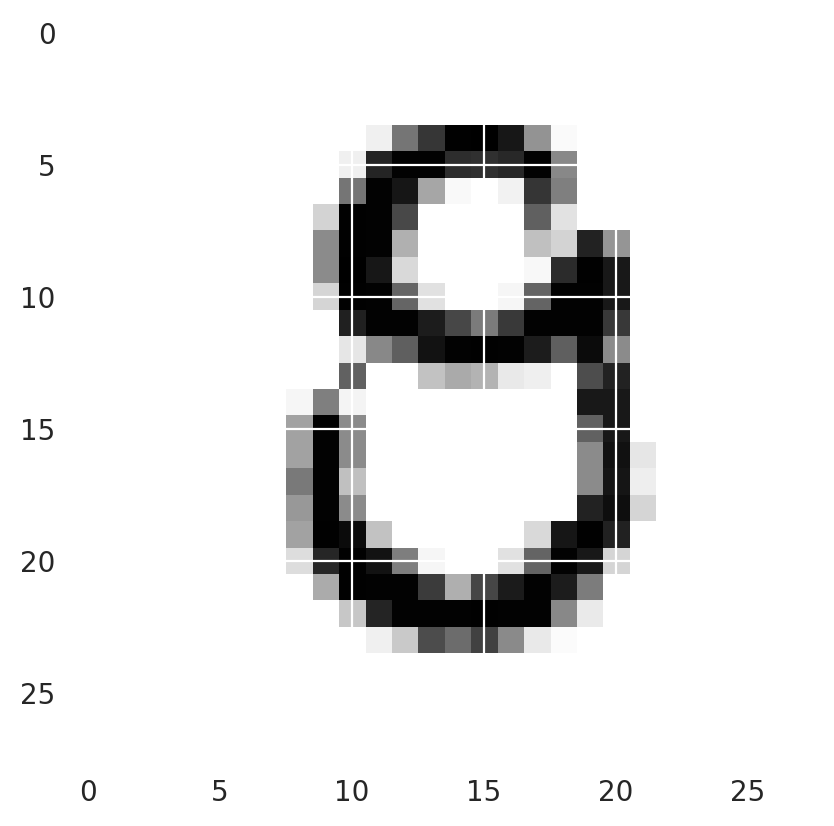

Observation index: 97. Class: 9. Prediction: 8.


In [8]:
i = mistakes[13]
plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()
print('Observation index: {0}. Class: {1}. Prediction: {2}.'.format(i, y_test[i], y_pred[i]))

Some datasets need to be preprocessed before a learning algorithm can be applied. The training dataset must be preprocessed without access to the test dataset, otherwise the resulting test accuracy after preprocessing is likely to overestimate the accuracy on unseen data.

The function ``make_pipeline`` allows chaining a sequence of preprocessing operations (such as individually standardizing each feature, which is accomplished by the class ``StandardScaler``) before a learning algorithm is applied. This function returns a ``Pipeline`` object that can be used to fit, predict, and score, just as any other classification algorithm in ``sklearn``. A ``Pipeline`` preprocesses incoming data appropriately before making predictions.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

knn_pipe.fit(X_train, y_train)
print('Test dataset accuracy: {0}.'.format(knn_pipe.score(X_test, y_test)))

Test dataset accuracy: 0.8525.


Consider the task of selecting the best possible number of neighbours k (a hyperparameter) for the k-nearest neighbour classification algorithm.

As we have seen, a hyperparameter should not be chosen based on its performance on the test dataset. In that case, there would be no data left to enable a reliable estimate of how well this choice generalizes to unseen data. After all, this choice would have been based on the test dataset.

Therefore there exist two options: either the whole dataset is split into a training, a validation and a testing set, or k-fold cross validation is performed.

</br>

*Option 1*: **Exercise**

Split the whole dataset into training, validation and testing sets with ratios 65-15-20% and then perform  k-nearest neighbour with k = 5 and 15. Choose the best value for k according to the performance on the validation set.*italicized text*

In [10]:
# insert code here
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=0)


knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
knn_pipe.fit(X_train2, y_train2)
print('k=1: Test dataset accuracy: {0}.'.format(knn_pipe.score(X_valid, y_valid)))


knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn_pipe.fit(X_train2, y_train2)
print('k=5: Test dataset accuracy: {0}.'.format(knn_pipe.score(X_valid, y_valid)))


knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=15))
knn_pipe.fit(X_train2, y_train2)
print('k=15: Test dataset accuracy: {0}.'.format(knn_pipe.score(X_valid, y_valid)))

k=1: Test dataset accuracy: 0.8291666666666667.
k=5: Test dataset accuracy: 0.85.
k=15: Test dataset accuracy: 0.825.


</br>

Option 2: The function ``cross_validate`` conducts K-fold cross validation using a specified training dataset. Cross-validation involves splitting a training dataset into K folds of equal size (this K and the k in k-nn should not be confused; they are different). Each fold is used as a validation set (on which the performance is computed) when the remaining folds are used as an effective training set (where a classifier is learned). The parameter ``cv`` controls the number of folds K. The function returns a dictionary with statistics that include a list of accuracies (i.e. performance metric) that can be accessed by the keyword ``'test_score'``.

After a hyperparameter is selected by cross-validation, it can be used to fit a classifier to the entire training dataset, which can then be evaluated in the test dataset.

Once again, if any step leading to model selection is based on the resulting performance on the test dataset, the resulting test accuracy is likely to overestimate the accuracy of the model on unseen data.

In [11]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_15 = KNeighborsClassifier(n_neighbors=15)

from sklearn.model_selection import cross_validate

# Note that the data was already implicitly shuffled by train_test_split
result_5 = cross_validate(knn_5, X_train, y_train, cv=5)
result_15 = cross_validate(knn_15, X_train, y_train, cv=5)

print('Average accuracy across folds (k = 5): {0}.'.format(result_5['test_score'].mean()))
print('Average accuracy across folds (k = 15): {0}.'.format(result_15['test_score'].mean()))

knn_5.fit(X_train, y_train)
print('Test dataset accuracy (k = 5): {0}.'.format(knn_5.score(X_test, y_test)))

Average accuracy across folds (k = 5): 0.884375.
Average accuracy across folds (k = 15): 0.8700000000000001.
Test dataset accuracy (k = 5): 0.875.


The class ``GridSearchCV`` offers a convenient way to choose hyperparameters based on cross-validation. Its constructor receives a classification algorithm object (such as a ``KNeighborsClassifier`` object) and a dictionary that maps hyperparameter names to lists of values that should be considered. Once the method ``GridSearchCV.fit`` is called, each possible combination of hyperparameters from each of the lists is evaluated using cross-validation. The best hyperparameter setting is then used to fit a classifier to the training dataset. After fitting, the ``GridSearchCV`` object can be used to predict and score just as any other classification algorithm in ``sklearn``.

In [12]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors': [1, 3, 5, 7, 9]}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, parameters, cv=5)
knn_cv.fit(X_train, y_train)

print('Best hyperparameter setting: {0}.'.format(knn_cv.best_estimator_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(knn_cv.best_score_))
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(knn_cv.score(X_test, y_test)))

Best hyperparameter setting: KNeighborsClassifier(n_neighbors=1).
Average accuracy across folds of best hyperparameter setting: 0.899375.
Test dataset accuracy of best hyperparameter setting: 0.8925.


Accuracy is not the only classification performance metric available on ``sklearn``. For instance, it is possible to compute the precision and recall for each class by considering the remaining classes as beloging to a single (negative) class. This is accomplished by the function ``precision_recall_fscore_support``.

The function ``confusion_matrix`` creates a confusion matrix given a class/label array and a prediction array.

In [13]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

y_pred = knn_cv.predict(X_test)

precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred)
print('Precision for each class: {0}.'.format(precision))
print('Recall for each class: {0}.\n'.format(recall))

df = pd.DataFrame.from_records(confusion_matrix(y_test, y_pred))
print('Confusion matrix:')
display(df)

Precision for each class: [1.         0.8        0.975      0.975      0.85106383 0.82051282
 0.95121951 0.89473684 0.87096774 0.80555556].
Recall for each class: [0.97435897 1.         0.84782609 0.88636364 0.85106383 0.88888889
 0.92857143 0.87179487 0.84375    0.82857143].

Confusion matrix:


,0,1,2,3,4,5,6,7,8,9
0,38,0,0,0,0,0,1,0,0,0
1,0,40,0,0,0,0,0,0,0,0
2,0,3,39,0,0,2,0,1,1,0
3,0,1,1,39,0,1,0,1,0,1
4,0,3,0,0,40,0,0,1,0,3
5,0,0,0,1,0,32,1,0,2,0
6,0,1,0,0,1,1,39,0,0,0
7,0,0,0,0,2,1,0,34,0,2
8,0,2,0,0,0,2,0,0,27,1
9,0,0,0,0,4,0,0,1,1,29


As mentioned before, ``sklearn`` implements learning algorithms covered during the lectures:  [support vector machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [artificial neural networks](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), [decision trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), and [random forest classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

The interface provided by each of these learning algorithms is analogous to the interface provided by the k-nearest neighbour classification algorithm that we have used so far.

For instance, in order to train a random forest classifier composed of 100 decision trees, an object of the class ``RandomForestClassifier`` can be constructed with ``n_estimators`` set to 100. This object can be used to fit the training dataset and compute the accuracy on the test dataset.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))
print('Test dataset accuracy (random forest classifier): {0}.'.format(rfc.score(X_test, y_test)))

0.8925
Test dataset accuracy (random forest classifier): 0.8925.


</br>

##Exercise##

Train a support vector machine classifier using the same training dataset used in the previous sections and compute its accuracy on the corresponding test dataset. You can use the default hyperparameters for the class SVC from sklearn.svm

In [15]:
# insert code here
from sklearn import  svm

# Create a classifier: a support vector classifier
clf = svm.SVC()

clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
print('Test dataset accuracy (SVM classifier): {0}.'.format(clf.score(X_test, y_test)))

Test dataset accuracy (SVM classifier): 0.9275.


</br>

##Exercise##


Using the same training dataset used in the previous sections, employ ``GridSearchCV`` to find the best hyperparameter settings based on 5-fold cross-validation for a ``RandomForestClassifier``. Consider ``n_estimators`` $ \in \{ 50, 100, 200\}$ and ``max_features`` $ \in \{0.1, 0.25\}$. Use the default values for the remaining hyperparameters. Compute the accuracy of the best model on the corresponding test dataset.

In [16]:
# insert code here
parameters = {'n_estimators': [50, 100, 200], 'max_features': [0.1, 0.25]}

rfc = RandomForestClassifier()

rfc_cv = GridSearchCV(rfc, parameters, cv=5)
rfc_cv.fit(X_train, y_train)

print('Best hyperparameter setting: {0}.'.format(rfc_cv.best_estimator_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(rfc_cv.best_score_))
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(rfc_cv.score(X_test, y_test)))

Best hyperparameter setting: RandomForestClassifier(max_features=0.1, n_estimators=200).
Average accuracy across folds of best hyperparameter setting: 0.9118749999999999.
Test dataset accuracy of best hyperparameter setting: 0.9.


</br>

## Clustering

The clustering algorithms implemented by ``sklearn`` have an interface that is similar to the interface for the classification algorithms.

The class ``KMeans`` implements the k-means clustering algorithm. The number of clusters ``n_clusters`` is a parameter for the constructor of this class.

The method ``KMeans.fit_predict`` is equivalent to a call to ``KMeans.fit`` followed by a call to ``KMeans.predict``, which is responsible for attributing each observation to a cluster. After the clustering is computed by a call to ``KMeans.fit``, the sum of squared errors of the clustering is available as a class variable named ``inertia_``.


In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
y_pred = kmeans.fit_predict(X)

print('Sum of squared errors (k = 10): {0}.'.format(kmeans.inertia_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Sum of squared errors (k = 10): 75582.515625.


In order to compare the quality of clusterings of the same dataset for different numbers of clusters, it is possible to employ both sums of squared errors and silhouette coefficients.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

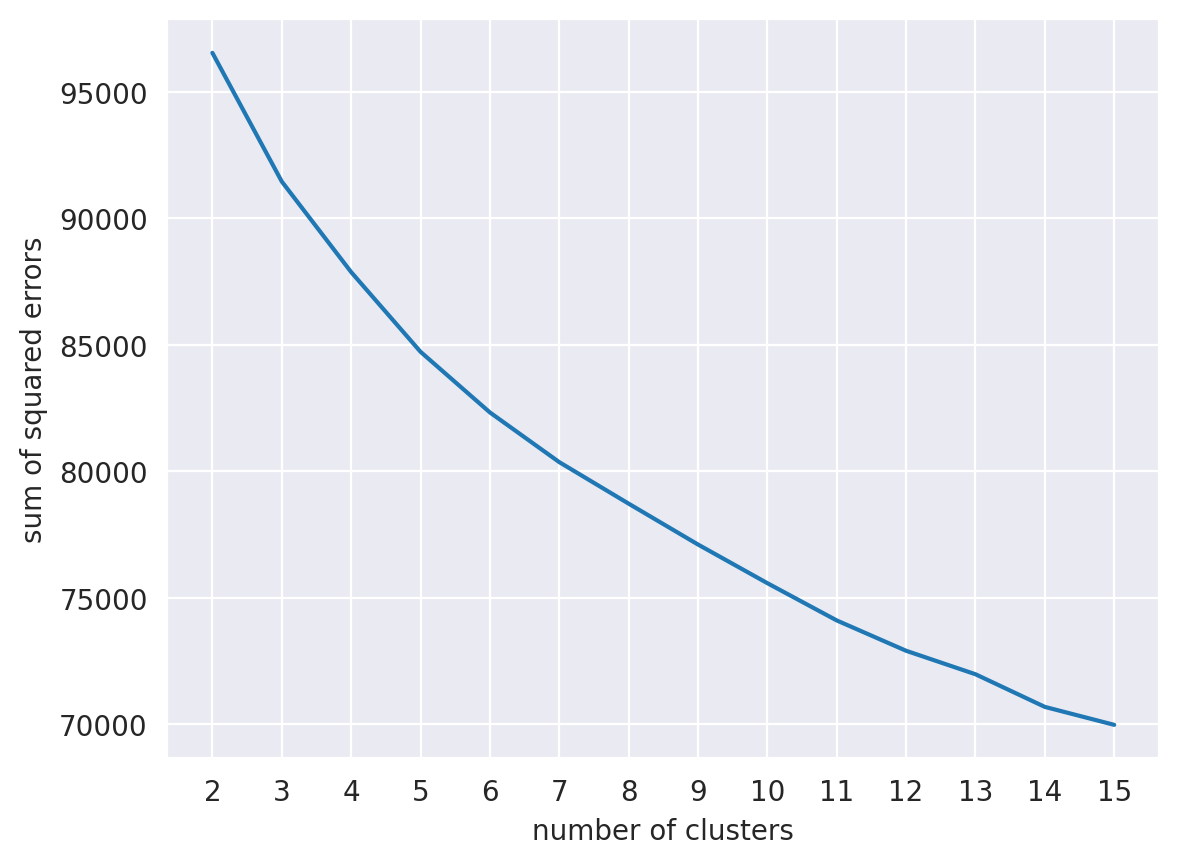

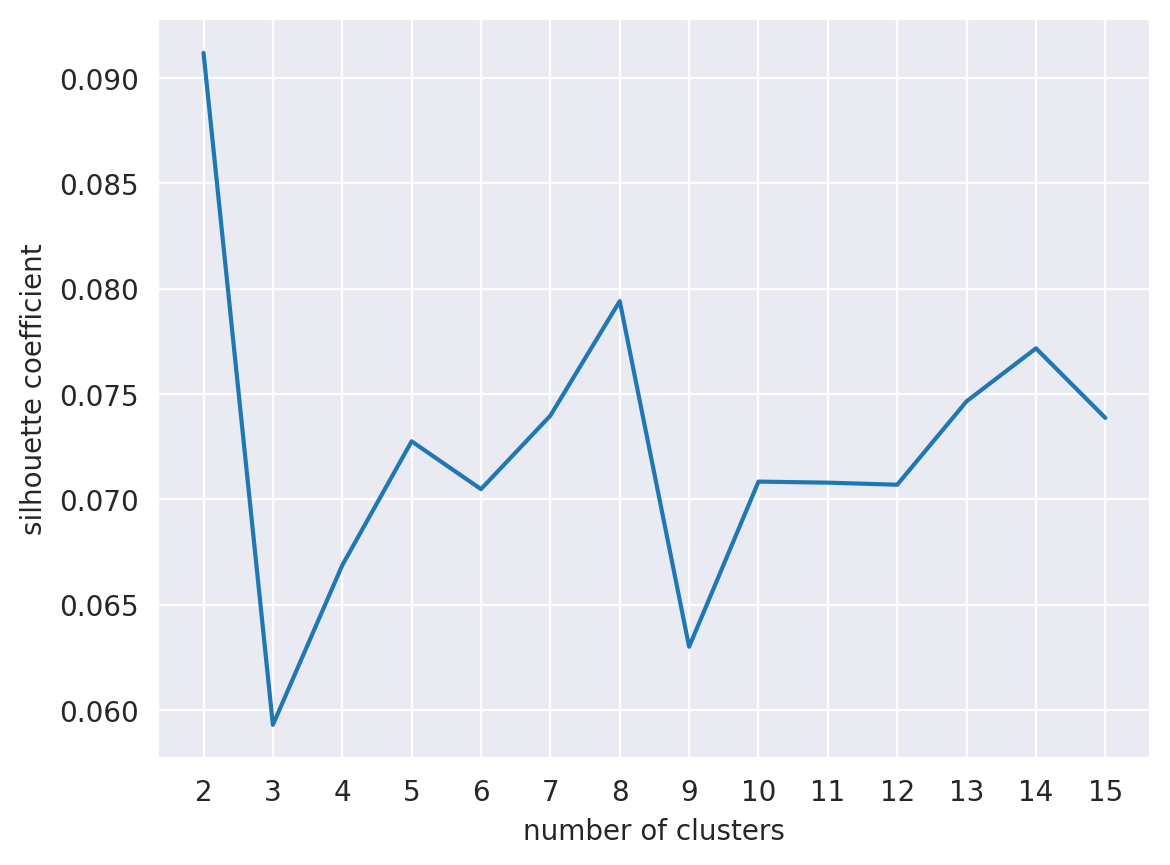

In [18]:
from sklearn.metrics import silhouette_score

max_k = 15

# Sum of squared errors for each k
sses = []

# Silhouette coefficient for each k
silhouettes = []

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    y_pred = kmeans.fit_predict(X)

    sses.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, y_pred))

# Plotting sums of squared errors
df = pd.DataFrame({'sum of squared errors': sses, 'number of clusters': list(range(2, max_k + 1))})
sns.lineplot(x='number of clusters', y='sum of squared errors', data=df)
plt.xticks(df['number of clusters'])
plt.show()

# Plotting silhouette coefficients
df = pd.DataFrame({'silhouette coefficient': silhouettes, 'number of clusters': list(range(2, max_k + 1))})
sns.lineplot(x='number of clusters', y='silhouette coefficient', data=df)
plt.xticks(df['number of clusters'])
plt.show()

A projection computed using t-stochastic neighbor embedding (implemented by the class ``TSNE``) can be used to visualise the results of clustering.

Recall that dimensionality reduction attemps to represent a dataset by a projection such that each point in the projection corresponds to an observation. The t-stochastic neighbor embedding algorithm attempts to preserve neighbourhoods of the dataset in the corresponding projection.

It is important to note that a projection is not, in general, a reliable representation of a dataset. Therefore, care must be taken before deriving conclusions from such visualisations.

Note that the numbers assigned to clusters are unlikely to match the numbers assigned to classes. Therefore, only relative colouring is important in the plots shown below.

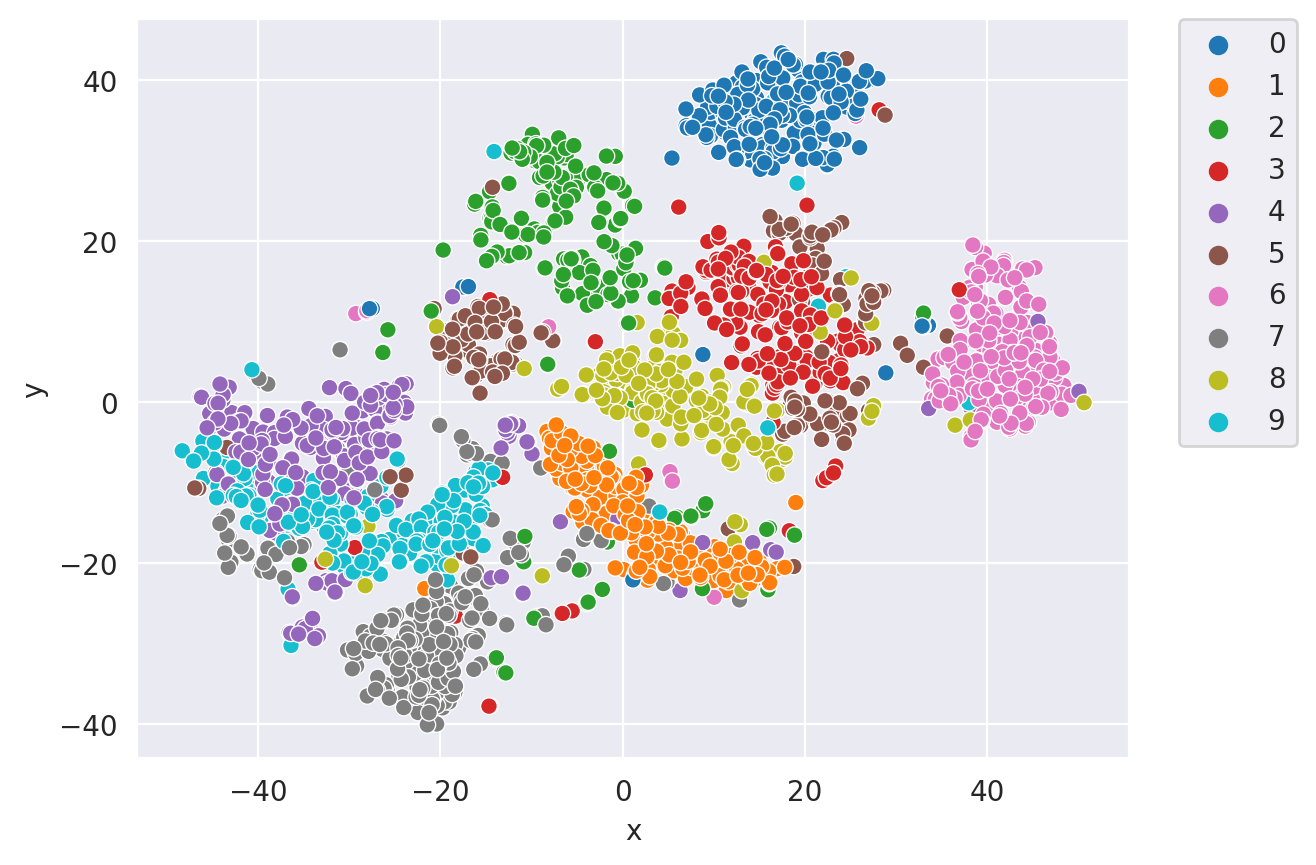

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


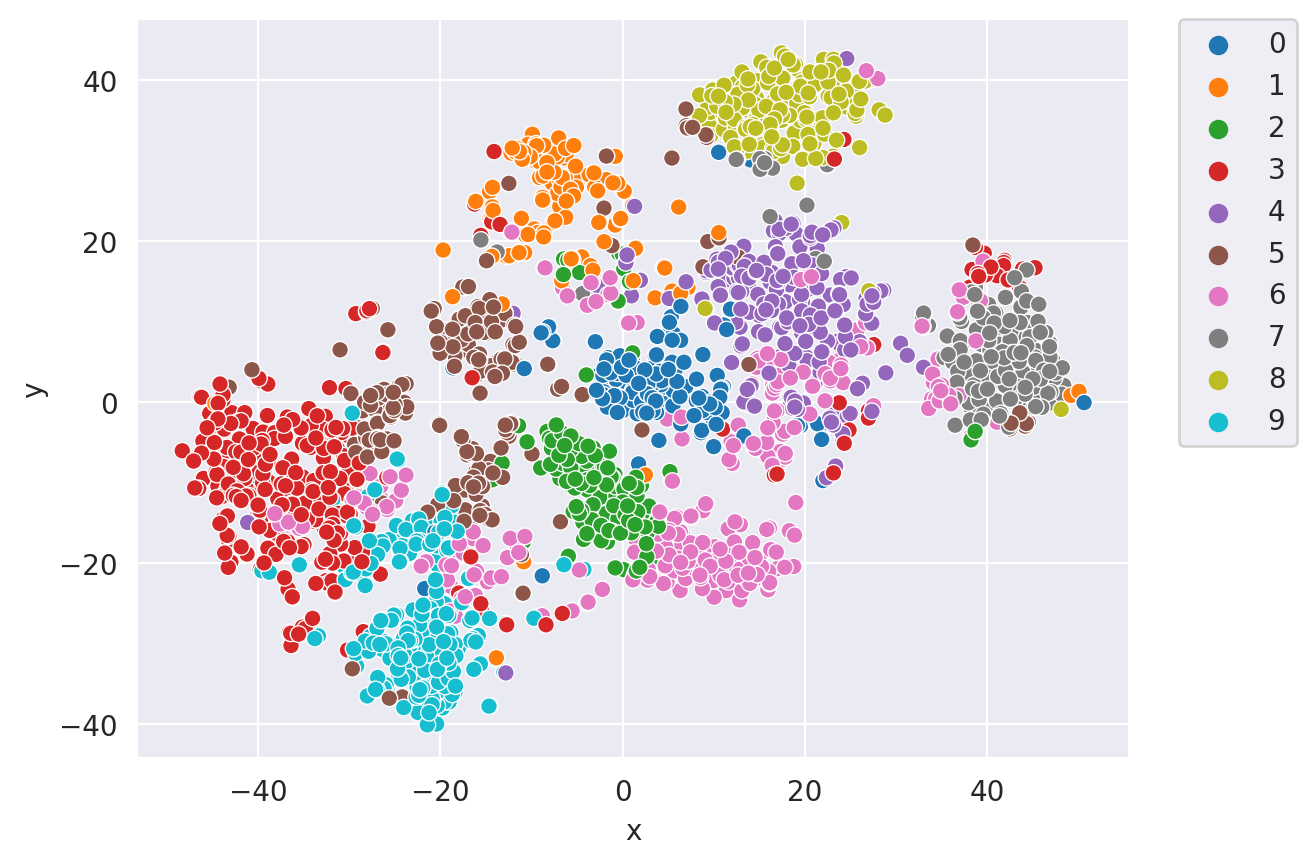

In [19]:
from sklearn.manifold import TSNE

# Computing a projection using t-stochastic neighbour embedding
embedding = TSNE(n_components=2, perplexity=50, random_state=0)
Xp = embedding.fit_transform(X)

# Plotting projection colored by classes
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1], 'class': y})
sns.scatterplot(x='x', y='y', hue='class', palette=sns.color_palette(), data=df_projection)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

kmeans = KMeans(n_clusters=10, random_state=0)
y_pred = kmeans.fit_predict(X)

# Plotting projection colored by clusters
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1], 'cluster': y_pred})
sns.scatterplot(x='x', y='y', hue='cluster', palette=sns.color_palette(), data=df_projection)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()